Problem Statement: Using historical data of city buses or metro systems (including traffic, time of
 day, and weather), predict the likelihood and duration of delays.

| Column Name             | Description                                                                      |
| ----------------------- | -------------------------------------------------------------------------------- |
| **trip\_id**            | Unique identifier for each trip (1 → n).                                         |
| **route\_id**           | Bus/train route ID (random between 1–50).                                        |
| **time\_of\_day**       | Time category when trip started (`Morning`, `Afternoon`, `Evening`, `Night`).    |
| **day\_of\_week**       | Day on which the trip occurred (`Mon–Sun`).                                      |
| **traffic\_level**      | Traffic conditions during the trip (`Low`, `Medium`, `High`).                    |
| **weather**             | Weather condition (`Clear`, `Rain`, `Snow`, `Fog`).                              |
| **scheduled\_duration** | Scheduled trip duration in minutes (10–90).                                      |
| **distance\_km**        | Trip distance in kilometers (2–30).                                              |
| **num\_passengers**     | Number of passengers onboard (10–120).                                           |
| **delay\_minutes**      | Actual delay in minutes (calculated, clipped 0–60).                              |
| **delay\_flag**         | **Target column** → Binary indicator (1 if delayed more than 5 minutes, else 0). |


Target column = delay_flag

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [93]:
from faker import Faker

fake = Faker()
np.random.seed(42)

n = 300000
data = []

for i in range(1, n+1):
    route_id = np.random.randint(1, 50)
    time_of_day = np.random.choice(["Morning","Afternoon","Evening","Night"])
    day_of_week = np.random.choice(
        ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    traffic_level = np.random.choice(["Low","Medium","High"], p=[0.3,0.4,0.3])
    weather = np.random.choice(["Clear","Rain","Snow","Fog"], p=[0.6,0.25,0.1,0.05])
    scheduled_duration = np.random.randint(10, 90)
    distance_km = round(np.random.uniform(2, 30), 2)
    num_passengers = np.random.randint(10, 120)

    # Delay calculation
    traffic_map = {"Low":0,"Medium":1,"High":2}
    weather_map = {"Clear":0,"Rain":1,"Snow":2,"Fog":1}
    time_map = {"Morning":1,"Afternoon":2,"Evening":2,"Night":0}

    delay_minutes = (
        traffic_map[traffic_level]*5 +
        weather_map[weather]*4 +
        time_map[time_of_day]*2 +
        (num_passengers/50) +
        np.random.normal(0, 3)
    )
    delay_minutes = max(0, min(60, delay_minutes))  # clip 0–60
    delay_flag = 1 if delay_minutes > 5 else 0

    data.append([
        i, route_id, time_of_day, day_of_week, traffic_level, weather,
        scheduled_duration, distance_km, num_passengers,
        round(delay_minutes,2), delay_flag
    ])

cols = ["trip_id","route_id","time_of_day","day_of_week","traffic_level","weather",
        "scheduled_duration","distance_km","num_passengers","delay_minutes","delay_flag"]

df = pd.DataFrame(data, columns=cols)
print(df.head())
df.to_csv("public_transit_delay_dataset.csv", index=False)


   trip_id  route_id time_of_day day_of_week traffic_level weather  \
0        1        39       Night      Friday           Low    Rain   
1        2        36       Night   Wednesday           Low     Fog   
2        3        21     Morning    Thursday        Medium   Clear   
3        4        44     Evening    Thursday        Medium   Clear   
4        5        39   Afternoon    Thursday          High   Clear   

   scheduled_duration  distance_km  num_passengers  delay_minutes  delay_flag  
0                  30         6.37              92           5.56           1  
1                  39         7.95              73           2.67           0  
2                  58        16.69              51           7.27           1  
3                  60        21.05              82          10.15           1  
4                  18         2.45              11          12.41           1  


In [94]:
df.head()

,trip_id,route_id,time_of_day,day_of_week,traffic_level,weather,scheduled_duration,distance_km,num_passengers,delay_minutes,delay_flag
0,1,39,Night,Friday,Low,Rain,30,6.37,92,5.56,1
1,2,36,Night,Wednesday,Low,Fog,39,7.95,73,2.67,0
2,3,21,Morning,Thursday,Medium,Clear,58,16.69,51,7.27,1
3,4,44,Evening,Thursday,Medium,Clear,60,21.05,82,10.15,1
4,5,39,Afternoon,Thursday,High,Clear,18,2.45,11,12.41,1


In [95]:
df.shape

(300000, 11)

In [96]:
df.describe()

,trip_id,route_id,scheduled_duration,distance_km,num_passengers,delay_minutes,delay_flag
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,150000.500000,24.999477,49.536650,15.991913,64.553230,10.829340,0.829190
std,86602.684716,14.148505,23.095787,8.081406,31.700277,5.760094,0.376343
min,1.000000,1.000000,10.000000,2.000000,10.000000,0.000000,0.000000
25%,75000.750000,13.000000,30.000000,8.990000,37.000000,6.620000,1.000000
50%,150000.500000,25.000000,50.000000,15.990000,65.000000,10.700000,1.000000
75%,225000.250000,37.000000,70.000000,22.980000,92.000000,14.840000,1.000000
max,300000.000000,49.000000,89.000000,30.000000,119.000000,33.690000,1.000000


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_id             300000 non-null  int64  
 1   route_id            300000 non-null  int64  
 2   time_of_day         300000 non-null  object 
 3   day_of_week         300000 non-null  object 
 4   traffic_level       300000 non-null  object 
 5   weather             300000 non-null  object 
 6   scheduled_duration  300000 non-null  int64  
 7   distance_km         300000 non-null  float64
 8   num_passengers      300000 non-null  int64  
 9   delay_minutes       300000 non-null  float64
 10  delay_flag          300000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 25.2+ MB


In [98]:
df.isnull().sum()

trip_id               0
route_id              0
time_of_day           0
day_of_week           0
traffic_level         0
weather               0
scheduled_duration    0
distance_km           0
num_passengers        0
delay_minutes         0
delay_flag            0
dtype: int64

<Axes: xlabel='trip_id'>

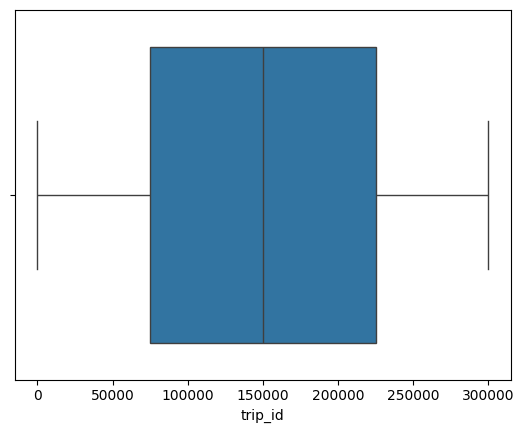

In [99]:
sns.boxplot(x="trip_id",data=df)

<Axes: xlabel='route_id'>

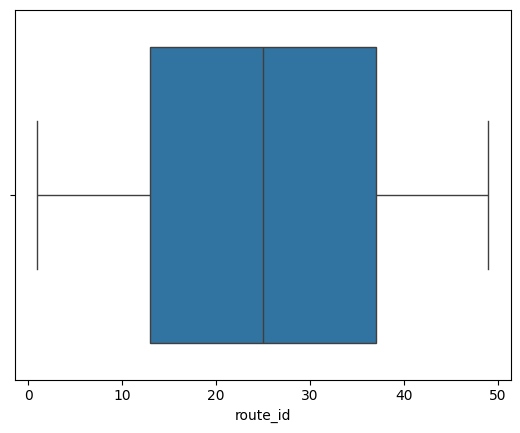

In [100]:
sns.boxplot(x="route_id",data=df)

<Axes: xlabel='scheduled_duration'>

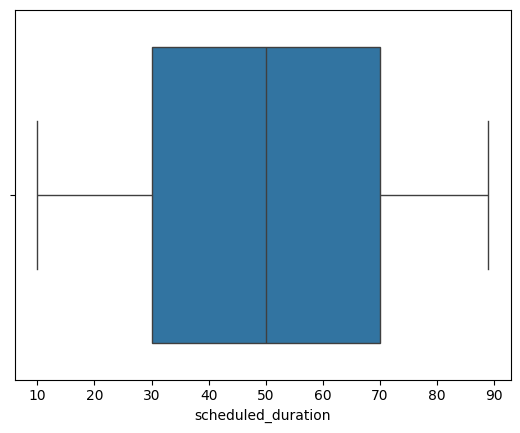

In [101]:
sns.boxplot(x="scheduled_duration",data=df)

<Axes: xlabel='distance_km'>

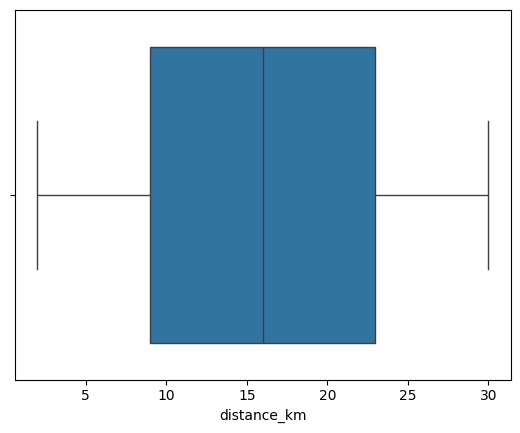

In [102]:
sns.boxplot(x="distance_km",data=df)

<Axes: xlabel='distance_km'>

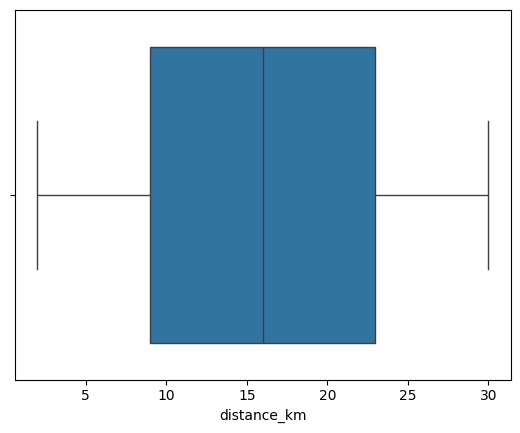

In [103]:
sns.boxplot(x="distance_km",data=df)

<Axes: xlabel='num_passengers'>

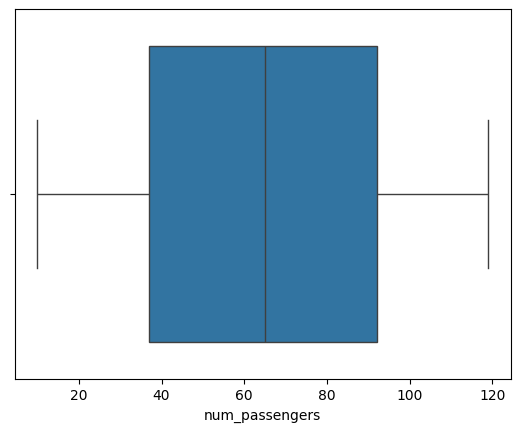

In [104]:
sns.boxplot(x="num_passengers",data=df)

<Axes: xlabel='delay_minutes'>

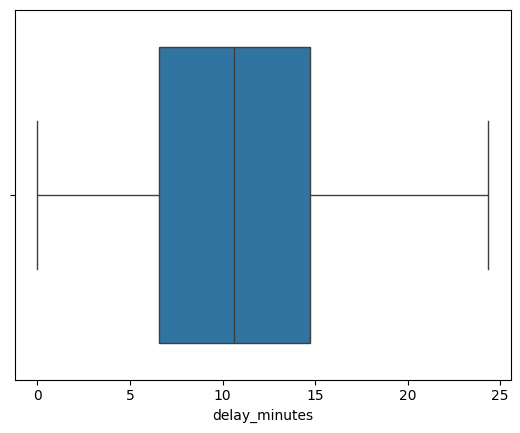

In [128]:
sns.boxplot(x="delay_minutes",data=df)

<Axes: xlabel='delay_minutes'>

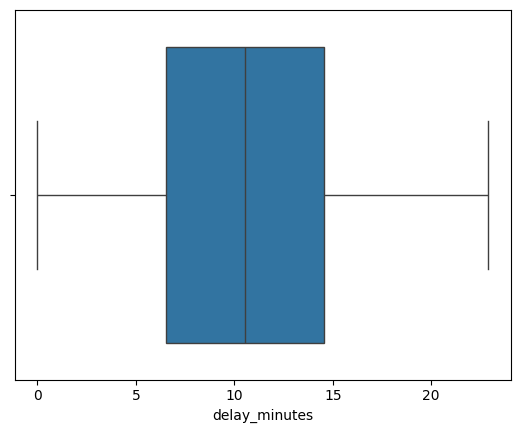

In [129]:
df=df[df['delay_minutes']<df['delay_minutes'].quantile(0.99)]
sns.boxplot(x="delay_minutes",data=df)

<Axes: xlabel='delay_flag'>

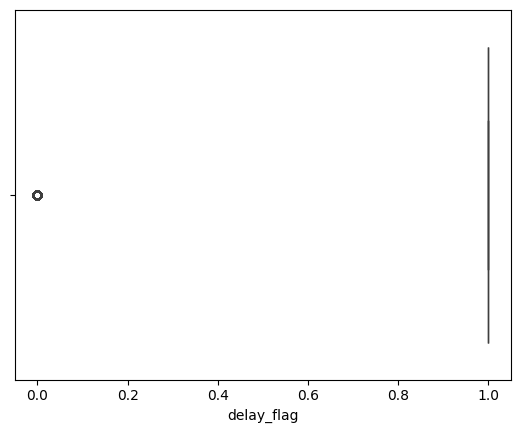

In [107]:
sns.boxplot(x="delay_flag",data=df)

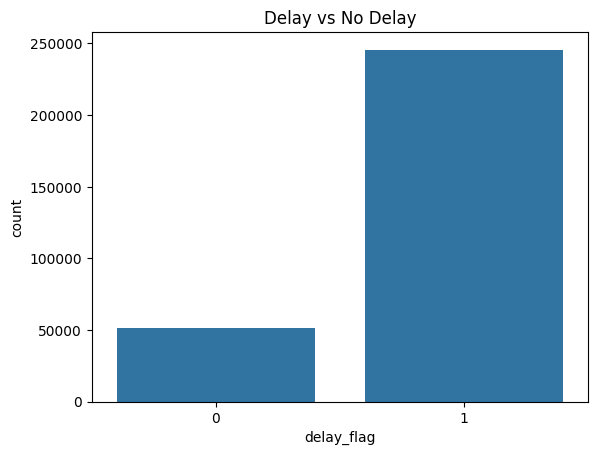

In [108]:
sns.countplot(x="delay_flag", data=df)
plt.title("Delay vs No Delay")
plt.show()

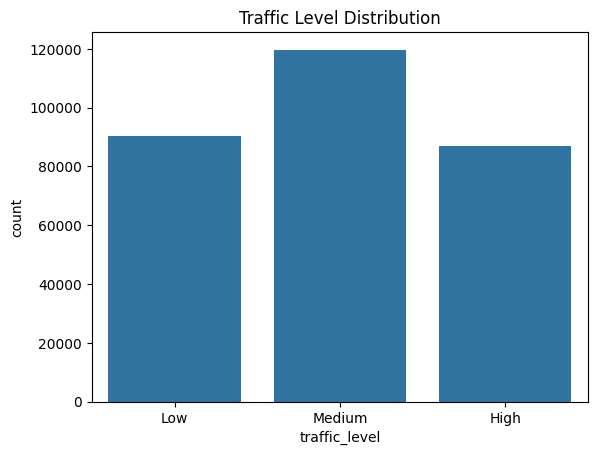

In [109]:
sns.countplot(x="traffic_level", data=df)
plt.title("Traffic Level Distribution")
plt.show()

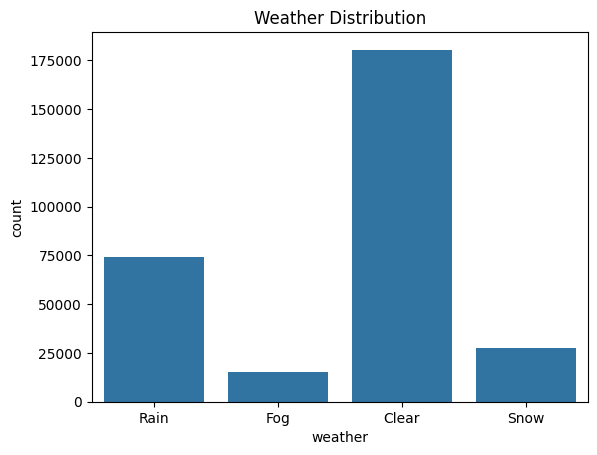

In [110]:
sns.countplot(x="weather", data=df)
plt.title("Weather Distribution")
plt.show()

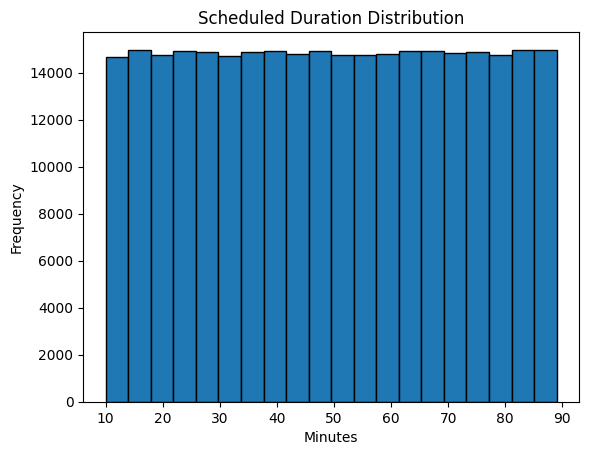

In [111]:
df["scheduled_duration"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Scheduled Duration Distribution")
plt.xlabel("Minutes")
plt.show()

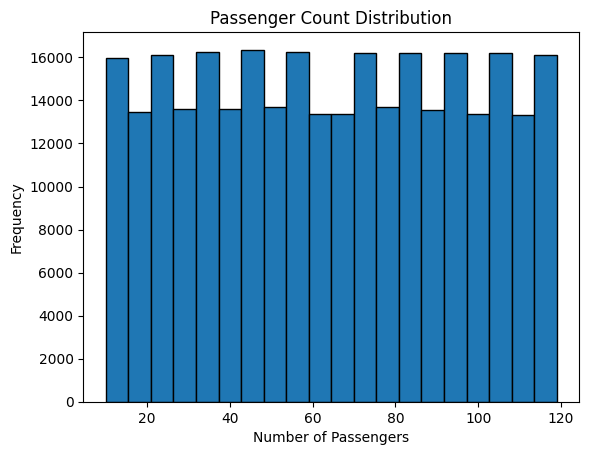

In [112]:
df["num_passengers"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Passenger Count Distribution")
plt.xlabel("Number of Passengers")
plt.show()

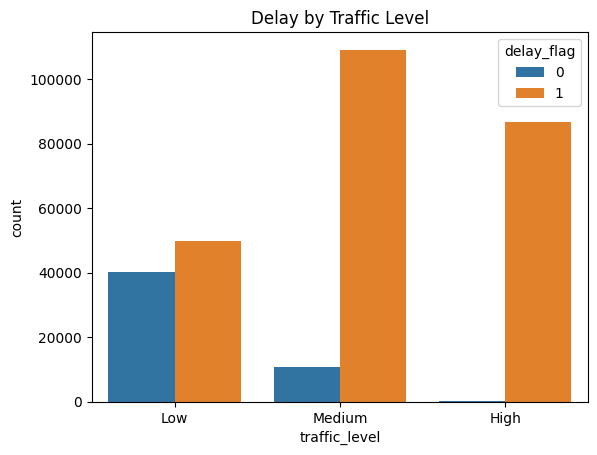

In [113]:
sns.countplot(x="traffic_level", hue="delay_flag", data=df)
plt.title("Delay by Traffic Level")
plt.show()


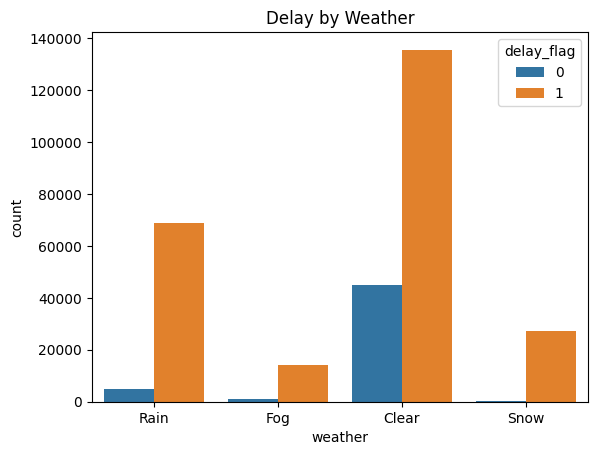

In [114]:
sns.countplot(x="weather", hue="delay_flag", data=df)
plt.title("Delay by Weather")
plt.show()

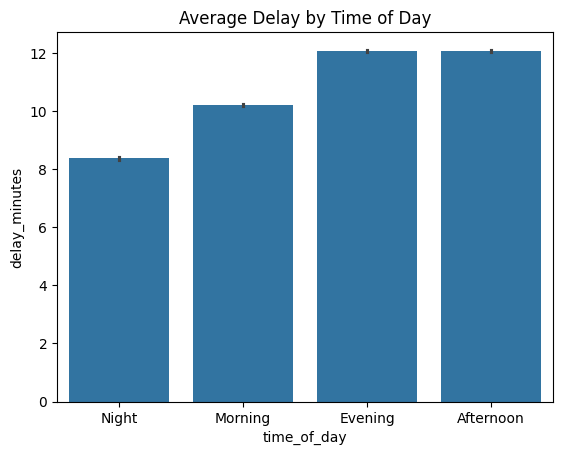

In [115]:
sns.barplot(x="time_of_day", y="delay_minutes", data=df, estimator="mean")
plt.title("Average Delay by Time of Day")
plt.show()

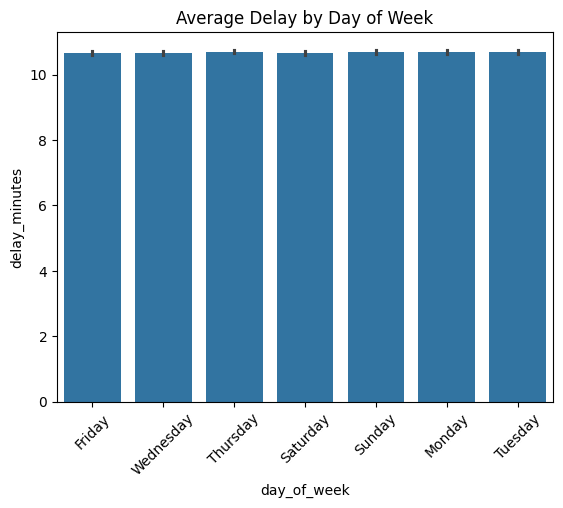

In [116]:
sns.barplot(x="day_of_week", y="delay_minutes", data=df, estimator="mean")
plt.title("Average Delay by Day of Week")
plt.xticks(rotation=45)
plt.show()

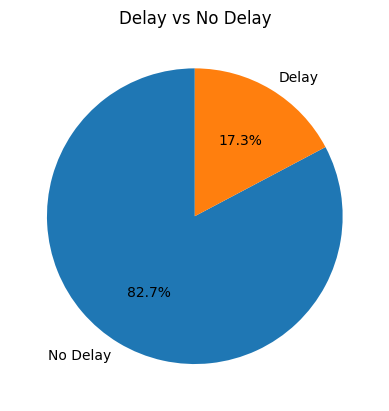

In [117]:
df["delay_flag"].value_counts().plot.pie(autopct='%1.1f%%', labels=["No Delay","Delay"], startangle=90)
plt.title("Delay vs No Delay")
plt.ylabel("")
plt.show()

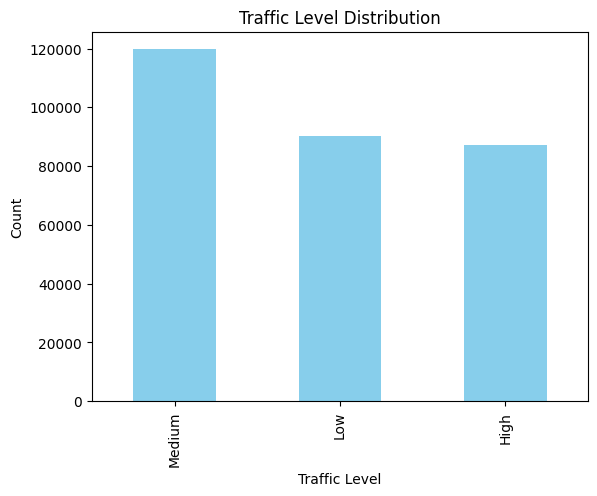

In [118]:
df["traffic_level"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Traffic Level Distribution")
plt.xlabel("Traffic Level")
plt.ylabel("Count")
plt.show()

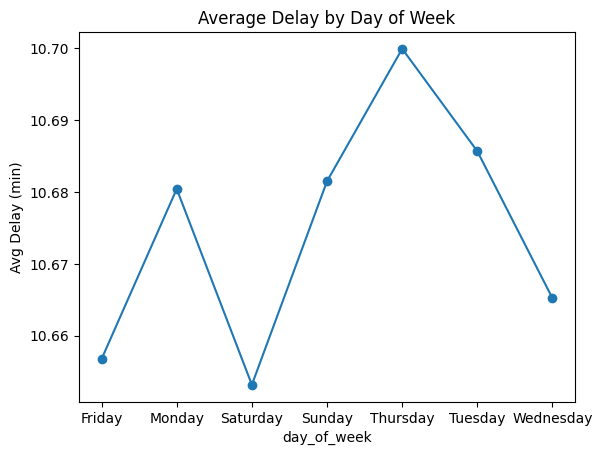

In [119]:
df.groupby("day_of_week")["delay_minutes"].mean().plot(kind="line", marker="o")
plt.title("Average Delay by Day of Week")
plt.ylabel("Avg Delay (min)")
plt.show()

In [120]:
num=df.select_dtypes(include='number')
num.corr()

,trip_id,route_id,scheduled_duration,distance_km,num_passengers,delay_minutes,delay_flag
trip_id,1.000000,-0.000891,0.001038,0.000723,0.000218,0.000290,0.000798
route_id,-0.000891,1.000000,0.000029,0.000847,0.001283,-0.000059,-0.000280
scheduled_duration,0.001038,0.000029,1.000000,0.000208,0.001523,0.001780,0.002704
distance_km,0.000723,0.000847,0.000208,1.000000,0.003283,0.001246,-0.001718
num_passengers,0.000218,0.001283,0.001523,0.003283,1.000000,0.099675,0.071466
delay_minutes,0.000290,-0.000059,0.001780,0.001246,0.099675,1.000000,0.671860
delay_flag,0.000798,-0.000280,0.002704,-0.001718,0.071466,0.671860,1.000000


<Axes: >

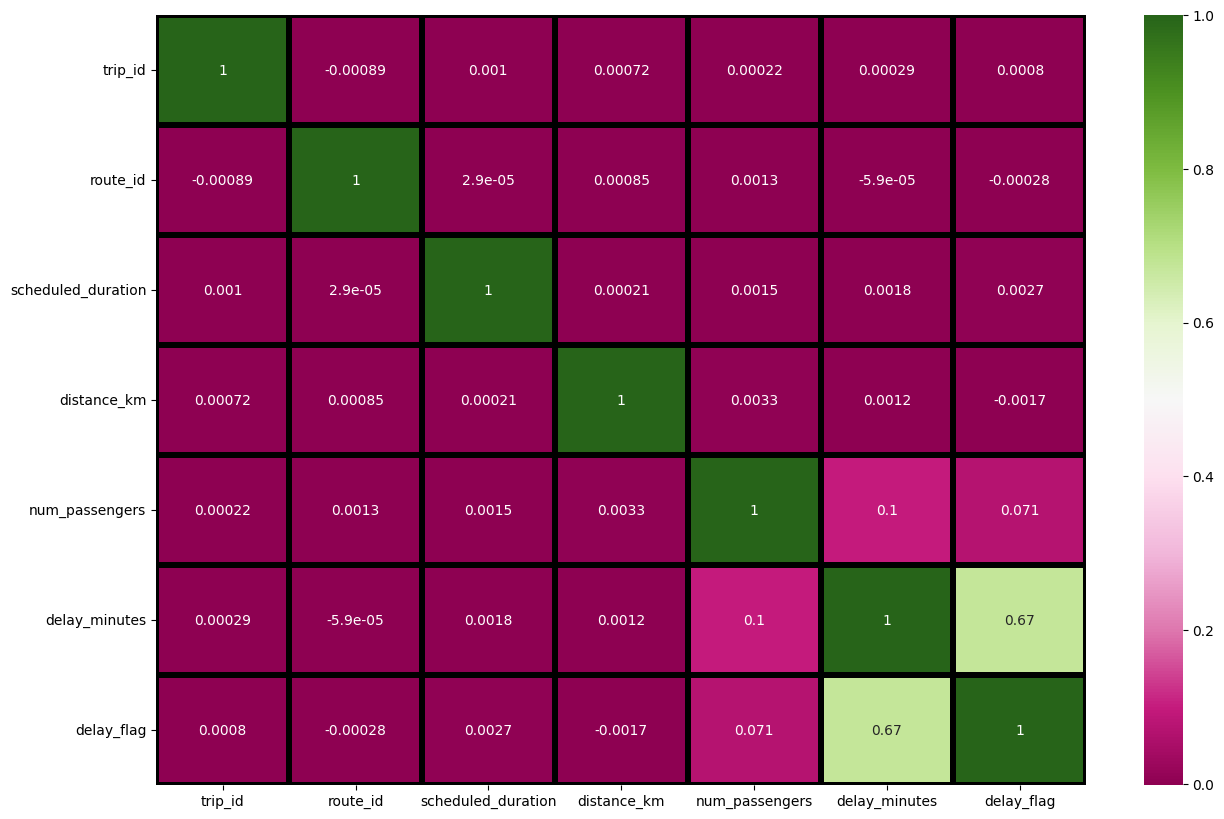

In [130]:
plt.figure(figsize=(15,10))
sns.heatmap(num.corr(),annot=True,linewidths=4,linecolor='k',cmap='PiYG')

In [131]:
dataset=pd.get_dummies(df,dtype=int,drop_first=True) 
dataset

,trip_id,route_id,scheduled_duration,distance_km,num_passengers,delay_minutes,delay_flag,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,...,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,traffic_level_Low,traffic_level_Medium,weather_Fog,weather_Rain,weather_Snow
0,1,39,30,6.37,92,5.56,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,2,36,39,7.95,73,2.67,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
2,3,21,58,16.69,51,7.27,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,4,44,60,21.05,82,10.15,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0
4,5,39,18,2.45,11,12.41,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299996,8,44,27.97,111,2.83,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
299996,299997,37,71,6.06,30,11.25,1,1,0,0,...,0,0,0,0,1,1,0,0,1,0
299997,299998,30,73,8.42,67,13.17,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
299998,299999,19,30,25.77,105,17.01,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [132]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293995 entries, 0 to 299999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trip_id                293995 non-null  int64  
 1   route_id               293995 non-null  int64  
 2   scheduled_duration     293995 non-null  int64  
 3   distance_km            293995 non-null  float64
 4   num_passengers         293995 non-null  int64  
 5   delay_minutes          293995 non-null  float64
 6   delay_flag             293995 non-null  int64  
 7   time_of_day_Evening    293995 non-null  int64  
 8   time_of_day_Morning    293995 non-null  int64  
 9   time_of_day_Night      293995 non-null  int64  
 10  day_of_week_Monday     293995 non-null  int64  
 11  day_of_week_Saturday   293995 non-null  int64  
 12  day_of_week_Sunday     293995 non-null  int64  
 13  day_of_week_Thursday   293995 non-null  int64  
 14  day_of_week_Tuesday    293995 non-null  i

In [133]:
X=dataset.drop(['delay_flag'],axis=1)
Y=dataset['delay_flag']

In [134]:
x_train, x_test,y_train, y_test = train_test_split(X, Y, test_size=0.2)
print('Shape of X train is-', x_train.shape)

print('Shape of X_test is-', x_test.shape)

print('Shape of y_train is-' ,y_train.shape)

print('Shape of y_test is-', y_test.shape)

Shape of X train is- (235196, 20)
Shape of X_test is- (58799, 20)
Shape of y_train is- (235196,)
Shape of y_test is- (58799,)


In [135]:
from sklearn.linear_model import LogisticRegression 
model = LogisticRegression() 
model.fit(x_train, y_train) 
prediction = model.predict(x_test)

In [136]:
r2_score(y_test,model.predict(x_test))

0.6887578735919698

In [137]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
m = XGBRegressor()
m.fit(x_train, y_train)
prediction = m.predict(x_test)
r2_score(y_test,m.predict(x_test))

0.9922447204589844